# Earth Analytics Capstone Project: Snow Observations Comparison for City of Boulder Water Resources Management 


> It is estimated that seasonal snowpack provides the water supply for almost two billion people in the Northern Hemisphere alone (Mankin, 2015). In the Western United States, 75% of the water supply begins as snow (Nijuis, M, 2014). Historically, data from the Natural Resources Conservation Service's [Snotel network](https://www.nrcs.usda.gov/wps/portal/wcc/home/snowClimateMonitoring/snowpack/snowpackMaps) has been used to predict stream flow from snow water equivalent. But as Climate change has increased uncertainties in snowpack accumulation and snow melt, our ability to estimate downstream water availability based on current measurement systems and historical patterns of snow, is changing as well. 

## Global Seasonal Snow Cover Extent from NASA's Terra Satellite MODIS data.

![Global Seasonal Snow Cover Extent](img/MOD10C1_M_SNOW.mov)
 NASA Earth Observatory (NASA, 2023).

> Numerous methods have been developed to better understand our changing snowpack, including physically based models, and integrating remote sensing data such as satellite or LiDAR, into snowpack models. Additional methods such as blending *insitu* data from snow surveys or Citizen Science campaigns such as [Community Snow Observations]( https://communitysnowobs.org), have been used to improve snowpack and snowmelt estimation as well.

> In 2013, NASA's Jet Propulsion Laboratory and The California Department of Water Resources, began a collaboration to better characterize snow depth and snow water equivalent (SWE) over critical watersheds. The Airborne Snow Observatory, a plane equipped with LiDAR and imaging spectrometer, compares non-snow-covered flight data to snow cover at different times of year to measure snow depth. A pyscially based distributed snowmelt model- iSNOBAL- is used to model SWE. The project was initiated in two US Watersheds, the Tuolemne River Basin, CA, and the Uncompahgre River Basin, CO- to help better estimate seasonal water supply for the millions of people who rely on water from these two basins. The program is now run by Airborne Snow Observatories, Inc (NASA Jet Propulsion Laboratory, 2019).

## Image from an ASO Flight over the San Joaquin Basin, CA in 2019
#### The ASO plane carries LiDAR and spectrometer instruments to measure snow depth to 10 centimeter precision and 3 meter resolution over the landscape.
![Image of ASO plane over San Joaquin Basin, CA in 2019](img/ASO_2019_flightimage.png)
NASA Jet Propulsion Laboratory, 2019.

## Project Rationale:
The City of Boulder, to better allocate, and plan for changes to its source water supply, is working to enhance the data it uses to understand seasonal snowpack and long-term trends through:

- utilizing existing snowpack data which has been collected in, and adjacent to the North Boulder Creek Watershed as part of the Niwot Ridge Long Term Ecological Research Project (LTER),

- funding Airborne Snow Observatory flights beginning in spring of 2023 to map snow depth and model snow water equivalent (SWE) across their source water locations.

## City of Boulder Source Water Map

#### The City of Boulder receives roughly one third of it's water supply from each of the locations shaded in blue. 

#### The Snow Observations Comparison Study Area is part of the North Boulder Creek Watershed.
![Map of City of Boulder Source Waters](img/3DWatershedDigital_1.png)
Map provided by Kate Dunlap, City of Boulder Senior Watershed Project Manager.

## Project Questions:
- How can existing Niwot Long Term Ecological Research (LTER) snowpack and hydrological data be used to better inform City of Boulder Water Resources Management short-term water supply decisions (source selection, leasing to agricultural partners, municipal drought declaration) or identify long-term trends in snowpack for future planning?
- Can this data be leveraged to increase the value of Airborne Snow Observatory flight data for water supply decision making?

## Project Outcomes:

- A python code which pulls LTER and ASO data into an annual report with yearly snowpack and hydrological metrics (easily readable and reproducible as new data is available each year).
- A data set of modeled snow water equivalent (SWE) for the upper Green Lakes Valley from LTER snow surveys.
- A data set of potential location(s) for additional ground-based observations to improve future ASO flight data modeling, and snowpack estimates for the upper Green Lakes Valley.

## Field Site Image

![Photo of Green Lakes Valley](img/SnowSurvey_2015_2.jpeg)
Measuring snowpack in the Green Lakes Valley, part of the North Boulder Creek Watershed, during an LTER Snow Survey, May 2015.

## Methods:

The Snow Observation Comparison Project begins with an exploratory analysis of Niwot LTER snowpack data sets from 1997 through present, in and adjacent to the Green Lakes Valley, part of the City of Boulder Watershed.  Using python code, data sets are visualized as tables and plots to determine next steps before more detailed analysis such as trends in peak snowpack amount and timing, can be completed.

#### Data Sets:
The LTER Data sets for this project are available on the Environmental Data Initiative Portal, found at https://edirepository.org. 

#### Data sets include:
- Snow Survey snow depth interpolation .tif files.

Yang, K., T. Erickson, and N. Molotch. 2021. Spatial distribution of snow depth for the Green Lakes Valley, 1997 - 2019 ver 2. Environmental Data Initiative. https://doi.org/10.6073/pasta/a997724eec6267db08f06240598f1426 (Accessed 2022-12-02).

- Snow Water Equivalent data from snowpits for Green Lakes Valley and Niwot Ridge LTER,

Williams, M., J. Morse, and Niwot Ridge LTER. 2022. Snow water equivalent data for Niwot Ridge and Green Lakes Valley, 1993 - ongoing. ver 18. Environmental Data Initiative. https://doi.org/10.6073/pasta/22d8cbaa21c2cf5211b37adcb5fd1a6f (Accessed 2023-05-05).

- Snow Depth data from snow grid snow stakes on Niwot Saddle

Muller, S. 2019. Saddle grid stake points, Niwot Ridge LTER, Colorado ver 1. Environmental Data Initiative. https://doi.org/10.6073/pasta/158e6ba4990f4365fc03de6bada4040a (Accessed 2023-05-05).

## Exploratory Analaysis of Niwot LTER Snow Data with Python

### Import Packages and Set Working Directory

In [1]:
# Import python packages needed to run code
import glob
import os
import pathlib
import re
import requests

import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
from fpdf import FPDF
import folium
from folium import plugins
import imageio
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from downloaders import edi_dataset_url
from downloaders import edi_dataset_download

# Set working directories
working_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'earthpy-downloads')

# Check working directory exists, create if does not
if not os.path.exists(working_dir):
    print('Path does not exist. Creating...')
    os.mkdirs(working_dir)
os.chdir(working_dir)

## Interactive Map of Study Area
#### Data set locations depicted in Folium Map:
- Snow Survey Snow Depth raster image
- Saddle Snow Water Equivalent and Snow Depth Measurements
- University Camp Snotel Site


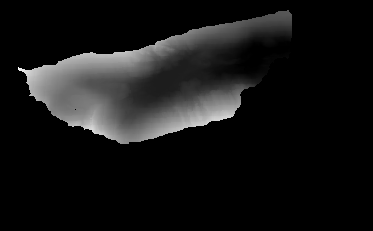

In [2]:
# Create Folium Map with site locations
glv_map = folium.Map(location=[40.0429, -105.5923],
                     tiles='Stamen Terrain',
                     zoom_start=12.5)


def create_folium_marker(site_name, site_type, lat, long):
    """Create folium marker for Green Lakes Valley stream
    gages and snow data sites.

    Parameters:
    ----------
    site_name : str
        Name of site.

    site_type : str
        Brief descriptive site type for marker title.

    lat : float
        Latitude of site.

    long : float
        Longitude of site.

    Returns
    -------
    Site marker to plot on folium map.
    """
    folium.Marker(
        location=[lat, long],
        popup='{site_name} {site_type}'.format(
            site_name=site_name, site_type=site_type),
        icon=folium.Icon()
    ).add_to(glv_map)


# Folium Marker names and parameters
create_folium_marker(
    'University Camp', 'Snotel', 40.0333, -105.5833)
create_folium_marker(
    'Saddle Snow Obs', '', 40.05499128, -105.5905549)

# Overlay Snow Survey onto Folium Map

# Define crs needed for Folium
dst_crs = 'EPSG:4326'

# Get download URL for elevation tif file of snow survey area
ss_dem_url = edi_dataset_url(
    'knb-lter-nwt', '284', '2', '2aeb95c2d38a5fb3a41774964a3972a2')

# Download elevation tif file
et.data.get_data(url=ss_dem_url)

# Set path to tif file
path = os.path.join(working_dir, 'glv_elev.ky.data.tif')

# Open the raster in rioxarray
ss_img = rxr.open_rasterio(path, masked=True)

# Reproject the raster to be the correct crs
ss_img = ss_img.rio.reproject(dst_crs)

# Replace all null values with the minimum value in the array
ss_plot = ss_img.where(~ss_img.isnull(), ss_img.min())

# Scale the array from 0 to 255
scaled_ss_img = es.bytescale(ss_plot.values[0])

map_bounds = [[40.03596706656645, -105.64836072080533],
              [40.06082109314164, -105.60822846144366]]

# Overlay raster image of snow survey area
glv_map.add_child(folium.raster_layers.ImageOverlay(
    scaled_ss_img, bounds=map_bounds, opacity=.4))

# Call Folium Map of Green Lakes Valley Watershed
glv_map

### Download Snow Survey .tif file data set

In [3]:
# Set list of identity_ids for downloading raster files

entity_ids = ['9b7867d3a3043f84f459a636f729ac26',
              '9954a9956f5fd89fc9e3e272e8f4648a',
              '625320ddc93ed7592d9ba436334708e6',
              '5bf8e6a7da271b924b4e9850ef200566',
              'fb0bc6e117fe310079bc57ff1130cc03',
              '2e0fddec2b1d8cd402fd064daa8a3fc3',
              '2221e36cb503198ec1ec034b2c6ffbc1',
              '302785a346c6f9b9a799b712f492f4e1',
              '0ee8cbcebf643f35da2383f7ede32196',
              '21073e90fc241aa6589d8fb707884a87',
              '835f7292c18d0c2660411739fd2c348a',
              'd604957336848f716b83f3f54dee61cf',
              'ede4ce370fb98659e55073035a8b0f50',
              '66c58735cda12448edd9b71c2bf6e1a6',
              '8a9303394a3383c4bb61a751c7a03441',
              '6b992fb96228afebc789f4903dadf7c6',
              'd2c1558494fac3509b44cc0ed0c78dff',
              '232590abbad7c23c7ba6ac46ed193834',
              'd58e5c9c857b94135caffcb9834c3548',
              'dbb9c490f075429ed55bf93d4a805035',
              '4d9aa6c3c4fdfc05060e0c7c0d00b5ef',
              '8ab60e7a83224a76df4c345d4893e200',
              '493a5d07d6b76c1eafb79f5e817f3855']


# Download raster files for 1997-2019 snow depth
sd_urls = [edi_dataset_url(
    'knb-lter-nwt', '284', 'newest', entity_id)
    for entity_id in entity_ids]

for url in sd_urls:
    et.data.get_data(url=url)

# Get list of swe tif files in working directory
sd_tifs = sorted(
    glob.glob(
        'glv_snow_interp_erickson_*.data.tif'),
    key=os.path.getmtime)

sd_dtms = [
    rxr.open_rasterio(
        sd_tif, masked=True).squeeze() for sd_tif in sd_tifs]

# Get CRS, bounds, and NAN values
print("The CRS for this data is:", sd_dtms[0].rio.crs)
print("The spatial extent is:", sd_dtms[0].rio.bounds())
print("The no data value is:", sd_dtms[0].rio.nodata)

The CRS for this data is: EPSG:6368
The spatial extent is: (444705.0, 4431955.0, 448105.0, 4434685.0)
The no data value is: nan


### Combine Snow Survey Snow Depth .tif Files to make Data Array & resample for plotting

In [4]:
# Concantenate snow depth raster files into data array
sd_da = xr.concat(sd_dtms, dim='date')

# Add dates to data array
sd_da['date'] = pd.to_datetime(sd_da['date'])
sd_da['date'] = pd.date_range('1997', periods=23, freq='Y')

# Find mean, median, max snow survey data for plotting
sd_mean = (sd_da.groupby('date').mean(...))
sd_median = (sd_da.groupby('date').median(...))
sd_max = (sd_da.groupby('date').max(...))

### Plot loop of snow survey snow depth raster images

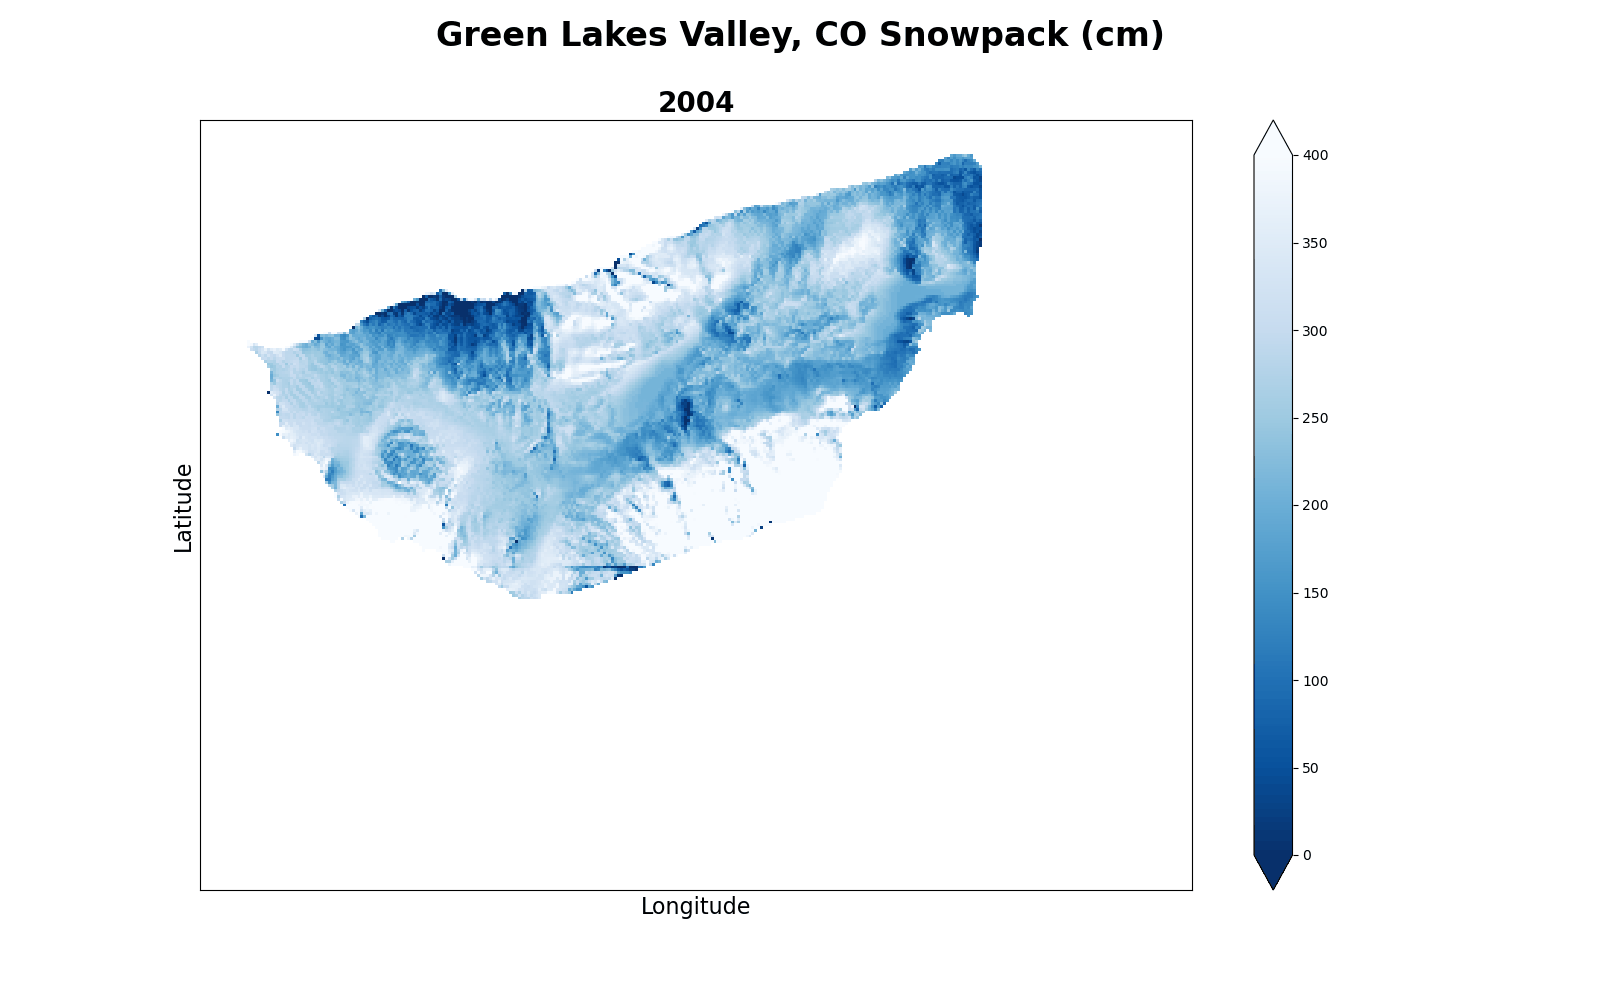

In [5]:
# List to iterate through snow depth data arrays
time = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


def create_frame(t):
    """Save snow depth raster data images to png file."""
    fig = sd_dtms[0+t].plot(
        cmap='Blues_r',
        vmax=400, vmin=0,
        figsize=(16, 10))
    plt.tick_params(left=False, right=False, labelleft=False,
                    labelbottom=False, bottom=False)
    plt.suptitle('Green Lakes Valley, CO Snowpack (cm)',
                 fontsize=24, fontweight='bold')
    plt.title(2004+t, fontsize=20, fontweight='bold')
    plt.ylabel('Latitude', fontsize=16)
    plt.xlabel('Longitude', fontsize=16)

    # Save .png to working directory
    plt.savefig(f'sd_{t}.png',
                transparent=False,
                facecolor='white')
    plt.close()


# Loop through create_frame function
for t in time:
    create_frame(t)
# Make list of frames to save as snow depth gif file
frames = []
for t in time:
    image = imageio.v2.imread(f'sd_{t}.png')
    frames.append(image)

# Save snow depth gif file
imageio.mimsave('sd.gif',
                frames,
                fps=.5,
                loop=4)

# Run snow depth gif
display.Image('sd.gif')

## Snow Survey Raster Images from 1997-2019
![Gif of snow survey raster images](img/sd.gif)


### Download LTER Time Series Snow Depth and Snow Water Equivalent Data Sets & resample for plotting

In [6]:
# Download snowpit SWE data for Niwot Ridge and Green Lakes Valley
snowpit_swe_df = edi_dataset_download(
    'swe', 'knb-lter-nwt',
    '96', 'newest', '48ebe14e5c16ca7ba8daa63feb7ce8fd')

# Subset dates to being with 1997 (1st year of snow survey)
snowpit_swe_df = snowpit_swe_df['1997-01-01': '2022-09-30']

# Find max SWE by year for saddle site
max_sdl_snowpit_swe_df = snowpit_swe_df.loc[
    snowpit_swe_df['samp_loc'] == 'SDL.006'].resample('Y').max('swe')

# Find mean SWE by year for saddle site
mean_sdl_snowpit_swe_df = snowpit_swe_df.loc[
    snowpit_swe_df['samp_loc'] == 'SDL.006'].resample('Y').mean('swe')

# Find max sample SWE by year for Green Lakes Valley site
max_glv_snowpit_swe_df = snowpit_swe_df.loc[
    snowpit_swe_df['samp_loc'] == 'NAV'].resample('Y').max('density')

In [7]:
# Download snow grid snow depth for Niwot Saddle
sdl_snow_df = edi_dataset_download(
    'sdl_sd', 'knb-lter-nwt',
    '31', 'newest', '6354b6f6c6d4ef8d6334cb3302644164')

# Convert mean depth object type to integer
sdl_snow_df['mean_depth'] = pd.to_numeric(
    sdl_snow_df['mean_depth'], errors='coerce')

# Subset dates to begin in 1997 (1st yr of snow survey)
sdl_snow_df = sdl_snow_df['1997-01-01': '2022-09-30']

# Resample maximum snow depth per year
sdl_snow_6_max_df = sdl_snow_df.resample('Y').max('mean_depth')

# Resample mean snow depth per year
sdl_snow_6_mean_df = sdl_snow_df.resample('Y').mean('mean_depth')

### Plot Snow Depth and Snow Water Equivalent data sets from Niwot Ridge and Green Lakes Valley

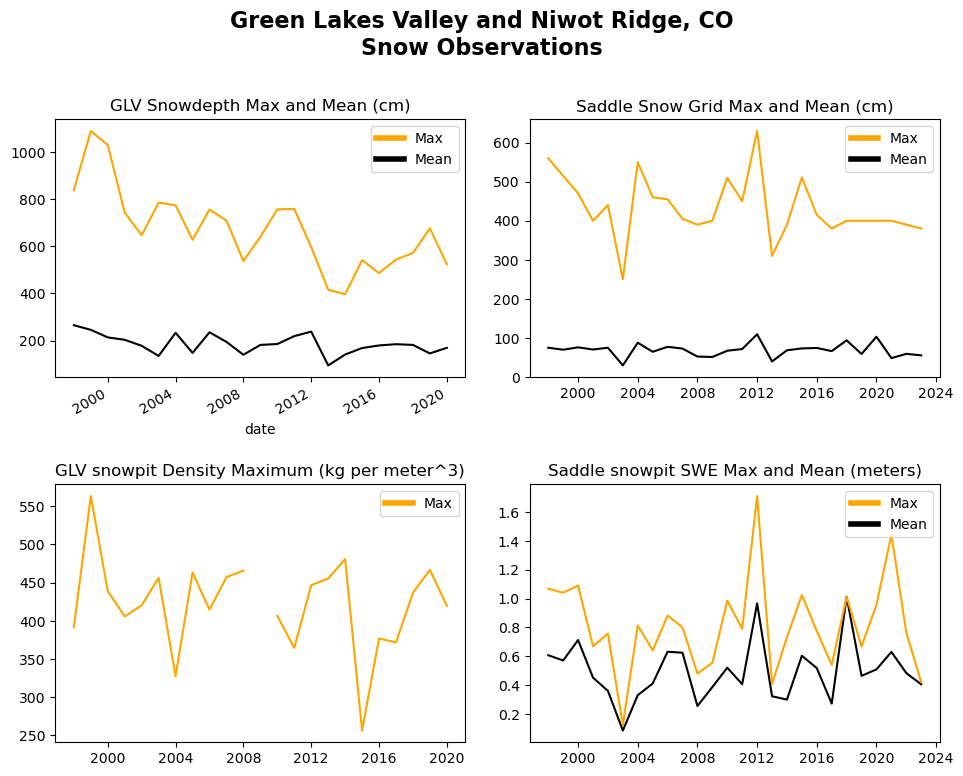

In [8]:
# Define custom legend elements
legend_elements_max_mean = [Line2D([0], [0], color='orange', lw=4, label='Max'),
                            Line2D([0], [0], color='black', lw=4, label='Mean')]
legend_elements_max = [Line2D([0], [0], color='orange', lw=4, label='Max')]

# Create plot figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
plt.suptitle(
    'Green Lakes Valley and Niwot Ridge, CO\n'
    'Snow Observations',
    fontweight='bold',
    fontsize=16)

# Plot snow survey snow depth
sd_max.plot(ax=ax1, color='orange')
sd_mean.plot(ax=ax1, color='black')
ax1.set_title('GLV Snowdepth Max and Mean (cm)')
ax1.legend(handles=legend_elements_max_mean, loc='upper right')

# Plot saddle snow depth
ax2.plot(sdl_snow_6_mean_df.mean_depth, color='black')
ax2.plot(sdl_snow_6_max_df.mean_depth, color='orange')
ax2.set_title('Saddle Snow Grid Max and Mean (cm)')
ax2.legend(handles=legend_elements_max_mean, loc='upper right')

# Plot GLV snow density
ax3.plot(max_glv_snowpit_swe_df.density, color='orange')
ax3.set_title('GLV snowpit Density Maximum (kg per meter^3)')
ax3.legend(handles=legend_elements_max, loc='upper right')

# Plot saddle SWE
ax4.plot(mean_sdl_snowpit_swe_df.swe, color='black')
ax4.plot(max_sdl_snowpit_swe_df.swe, color='orange')
ax4.set_title('Saddle snowpit SWE Max and Mean (meters)')
ax4.legend(handles=legend_elements_max_mean, loc='upper right')

plt.tight_layout(pad=2)

## Conclusions and Next Steps
  From preliminary data analysis:
  
- Snow depth and Snow Water Equivalent or Density are highly variable from year to year

- Maximum snow depth from Snow Survey data is declining over the period from 1997 to 2019

- Plot summaries are derived from mostly raw data, and need questionable and missing data filtered and infilled before accurate conclusions can be made

Immediate next steps may include filtering, or infilling questionable or missing data points from the analysis, and summarizing snowpack and snowmelt timing in addition to snowpack amounts.

Future steps will include:

- Python code to interpolate snow survey snow depth data after 2019, and adding 2022 and 2023 data into the analysis (no snow survey was conducted in 2020 or 2021 due to Covid-19 restrictions)
- Modeling Snow Water Equivalent from Snow Survey snow depth data

- Creating a draft PDF report with summary analysis for the City of Boulder

- Incorporating 2023 Airborne Snow Observatory data for the Boulder Creek Watershed into the analysis and report output as it becomes available

- Using ASO and/or snow survey data to create a data set of potential 'best' locations for new ground-based sensor observations with criteria such as a location that varies representatively with total snow water equivalent, is accessible in summer for regular maintenance, and is in a location suitable for RF or cell communication for remote data access.

## References:


Mankin, J. S., Viviroli, D., Singh, D., Hoekstra, A. Y., & Diffenbaugh, N. S. (2015). The potential for snow to supply human water demand in the present and future. Environmental Research Letters, 10(11), 114016. https://doi.org/10.1088/1748-9326/10/11/114016

NASA Jet Propulsion Laboratory. (2019). Airborne Snow Observatory (ASO). Retrieved May 5, 2023, from https://airbornescience.jpl.nasa.gov/tags/aso

NASA. (2023). MODIS/Terra Snow Cover Daily L3 Global 0.05Deg CMG (MOD10C1). Earth Observatory. Retrieved May 5, 2023, from https://earthobservatory.nasa.gov/global-maps/MOD10C1_M_SNOW

Nijhuis, M. (2014). When the snows fail. National Geographic. Retrieved April 9, 2023, from https://www.nationalgeographic.com/west-snow-fail/ 
National Aeronautics and Space Administration. (n.d.). MOD10C1.006 MODIS/Terra Snow Cover Daily L3 Global 0.05Deg CMG V006. NASA Earth Observatory. Retrieved May 3, 2023, from https://earthobservatory.nasa.gov/global-maps/MOD10C1_M_SNOW